# HW07: Кластеризация и unsupervised-эксперимент

**Выбранные датасеты:** Dataset-01, Dataset-02, Dataset-03

**Алгоритмы:** KMeans + DBSCAN

## 1. Импорт библиотек

In [7]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Создаём папки для артефактов
os.makedirs('artifacts/figures', exist_ok=True)
os.makedirs('artifacts/labels', exist_ok=True)

print('Библиотеки загружены')

Библиотеки загружены


## 2. Вспомогательные функции

In [8]:
def compute_metrics(X, labels):
    """Вычисляет метрики кластеризации (только для non-noise точек при DBSCAN)."""
    mask = labels != -1
    n_noise = (~mask).sum()
    noise_ratio = n_noise / len(labels)
    
    if mask.sum() < 2 or len(set(labels[mask])) < 2:
        return {'silhouette': np.nan, 'davies_bouldin': np.nan, 
                'calinski_harabasz': np.nan, 'noise_ratio': noise_ratio, 'n_clusters': len(set(labels[mask]))}
    
    X_clean = X[mask]
    labels_clean = labels[mask]
    
    return {
        'silhouette': silhouette_score(X_clean, labels_clean),
        'davies_bouldin': davies_bouldin_score(X_clean, labels_clean),
        'calinski_harabasz': calinski_harabasz_score(X_clean, labels_clean),
        'noise_ratio': noise_ratio,
        'n_clusters': len(set(labels_clean))
    }

def plot_pca_clusters(X, labels, title, filename):
    """PCA(2D) визуализация кластеров."""
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    plt.show()

def plot_silhouette_vs_k(X, k_range, title, filename):
    """График silhouette vs k для KMeans."""
    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = kmeans.fit_predict(X)
        scores.append(silhouette_score(X, labels))
    
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, scores, 'bo-', linewidth=2, markersize=8)
    best_k = k_range[np.argmax(scores)]
    plt.axvline(best_k, color='r', linestyle='--', label=f'Best k={best_k}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    plt.show()
    return best_k, max(scores)

print('Функции определены')

Функции определены


In [9]:
# ========================================
# Dataset 01: Числовые признаки в разных шкалах
# ========================================
print("="*60)
print("DATASET 01: Числовые признаки в разных шкалах")
print("="*60)

df1 = pd.read_csv('data/S07-hw-dataset-01.csv')
print(f'Размер: {df1.shape}')
print(f'\nПропуски: {df1.isnull().sum().sum()}')
print(f'\nТипы данных:\n{df1.dtypes}')
print(f'\nСтатистики:')
df1.describe()

DATASET 01: Числовые признаки в разных шкалах
Размер: (12000, 9)

Пропуски: 0

Типы данных:
sample_id      int64
f01          float64
f02          float64
f03          float64
f04          float64
f05          float64
f06          float64
f07          float64
f08          float64
dtype: object

Статистики:


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


X1 shape: (12000, 8)
Признаки масштабированы (StandardScaler)


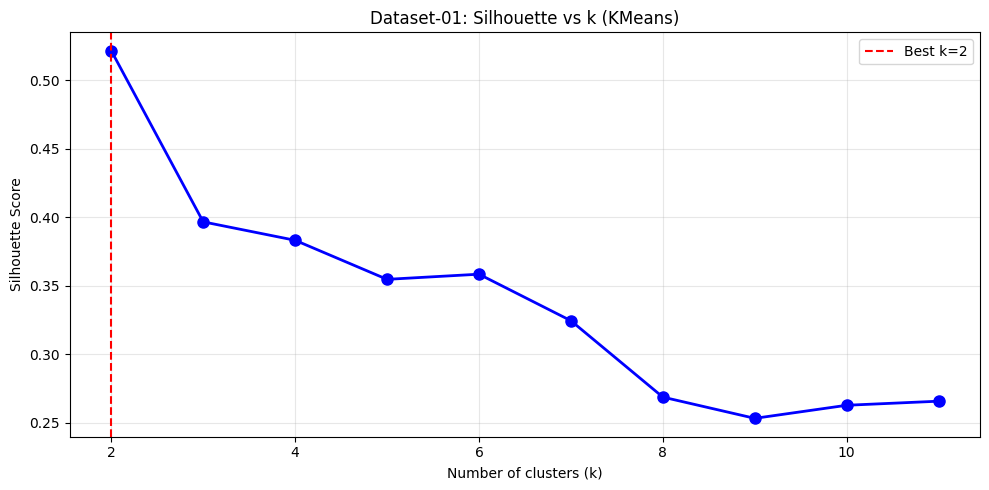


Лучшее k=2, silhouette=0.5216


In [10]:
# Препроцессинг Dataset-01
sample_id_1 = df1['sample_id'].values
X1_raw = df1.drop(columns=['sample_id']).values

scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X1_raw)
print(f'X1 shape: {X1.shape}')
print('Признаки масштабированы (StandardScaler)')

# KMeans: подбор k
k_range_1 = range(2, 12)
best_k_1, best_sil_1 = plot_silhouette_vs_k(
    X1, k_range_1, 
    'Dataset-01: Silhouette vs k (KMeans)',
    'artifacts/figures/silhouette_k_dataset01.png'
)
print(f'\nЛучшее k={best_k_1}, silhouette={best_sil_1:.4f}')

In [11]:
# KMeans с лучшим k
kmeans1 = KMeans(n_clusters=best_k_1, random_state=RANDOM_STATE, n_init=10)
labels_kmeans1 = kmeans1.fit_predict(X1)
metrics_kmeans1 = compute_metrics(X1, labels_kmeans1)

print(f'KMeans (k={best_k_1}):')
print(f"  Silhouette: {metrics_kmeans1['silhouette']:.4f}")
print(f"  Davies-Bouldin: {metrics_kmeans1['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz: {metrics_kmeans1['calinski_harabasz']:.1f}")

# DBSCAN: подбор параметров
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples_values = [5, 10]

dbscan_results_1 = []
for eps in eps_values:
    for min_s in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_s)
        labels = db.fit_predict(X1)
        m = compute_metrics(X1, labels)
        m['eps'] = eps
        m['min_samples'] = min_s
        dbscan_results_1.append(m)

dbscan_df_1 = pd.DataFrame(dbscan_results_1)
dbscan_df_1 = dbscan_df_1[dbscan_df_1['n_clusters'] >= 2].sort_values('silhouette', ascending=False)
print('\nDBSCAN результаты (top 3):')
dbscan_df_1.head(3)

KMeans (k=2):
  Silhouette: 0.5216
  Davies-Bouldin: 0.6853
  Calinski-Harabasz: 11787.0

DBSCAN результаты (top 3):


,silhouette,davies_bouldin,calinski_harabasz,noise_ratio,n_clusters,eps,min_samples
6,0.521640,0.68533,11786.954623,0.0,2,2.0,5
7,0.521640,0.68533,11786.954623,0.0,2,2.0,10
4,0.396789,0.96441,10446.597694,0.0,3,1.5,5


### Лучшее решение и визуализация для Dataset-01

DBSCAN (eps=2.0, min_samples=5)
  Silhouette: 0.5216, Шум: 0.0%

✅ Лучший метод: KMeans(k=2)


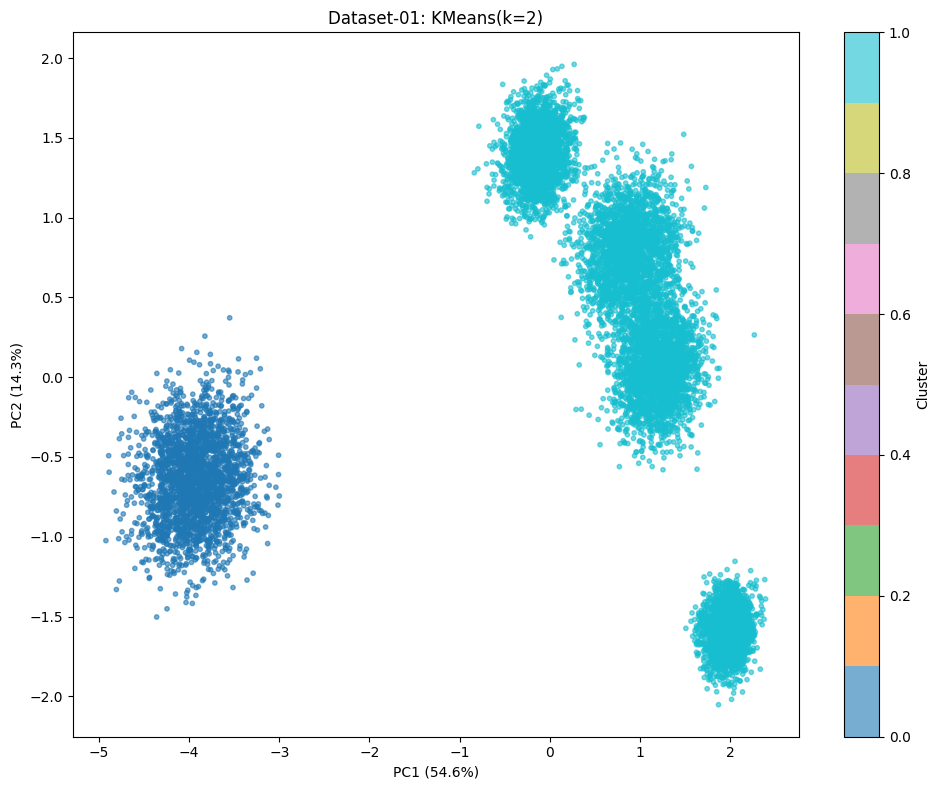

In [12]:
# Лучший DBSCAN (если есть)
if len(dbscan_df_1) > 0:
    best_db1 = dbscan_df_1.iloc[0]
    db1 = DBSCAN(eps=best_db1['eps'], min_samples=int(best_db1['min_samples']))
    labels_dbscan1 = db1.fit_predict(X1)
    metrics_dbscan1 = compute_metrics(X1, labels_dbscan1)
    print(f"DBSCAN (eps={best_db1['eps']}, min_samples={int(best_db1['min_samples'])})")
    print(f"  Silhouette: {metrics_dbscan1['silhouette']:.4f}, Шум: {metrics_dbscan1['noise_ratio']:.1%}")
else:
    metrics_dbscan1 = {'silhouette': -1}
    labels_dbscan1 = labels_kmeans1

# Выбор лучшего метода
if metrics_dbscan1['silhouette'] > metrics_kmeans1['silhouette']:
    best_labels_1, best_method_1, best_metrics_1 = labels_dbscan1, f"DBSCAN(eps={best_db1['eps']})", metrics_dbscan1
else:
    best_labels_1, best_method_1, best_metrics_1 = labels_kmeans1, f'KMeans(k={best_k_1})', metrics_kmeans1

print(f'\n✅ Лучший метод: {best_method_1}')
plot_pca_clusters(X1, best_labels_1, f'Dataset-01: {best_method_1}', 'artifacts/figures/pca_dataset01.png')


DATASET 02: Нелинейная структура + шум
Размер: (8000, 4)
Пропуски: 0

Статистики:


,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


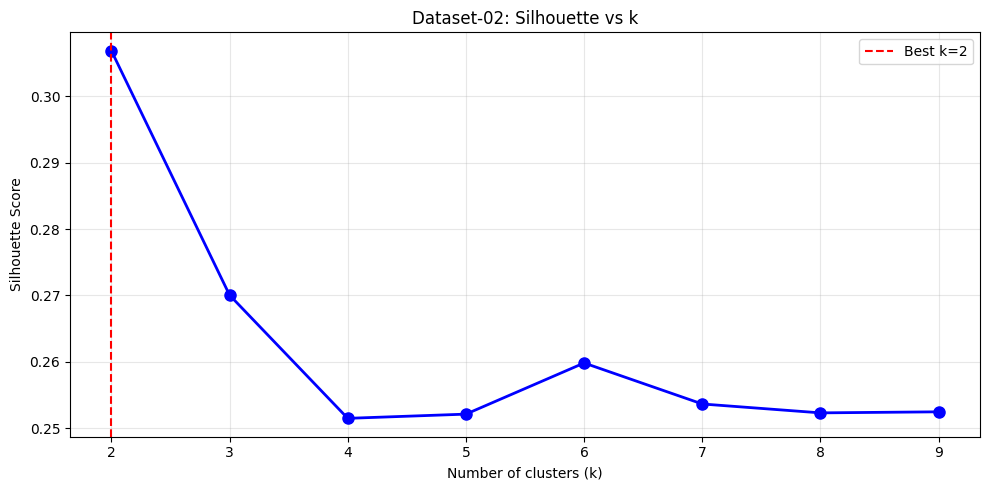

KMeans (k=2): sil=0.3069


In [13]:
# ========================================
# Dataset 02: Нелинейная структура + шум
# ========================================
print("\n" + "="*60)
print("DATASET 02: Нелинейная структура + шум")
print("="*60)

df2 = pd.read_csv('data/S07-hw-dataset-02.csv')
print(f'Размер: {df2.shape}')
print(f'Пропуски: {df2.isnull().sum().sum()}')
print(f'\nСтатистики:')
display(df2.describe())

# Препроцессинг
sample_id_2 = df2['sample_id'].values
X2_raw = df2.drop(columns=['sample_id']).values
scaler2 = StandardScaler()
X2 = scaler2.fit_transform(X2_raw)

# KMeans
k_range_2 = range(2, 10)
best_k_2, best_sil_2 = plot_silhouette_vs_k(X2, k_range_2, 
    'Dataset-02: Silhouette vs k', 'artifacts/figures/silhouette_k_dataset02.png')

kmeans2 = KMeans(n_clusters=best_k_2, random_state=RANDOM_STATE, n_init=10)
labels_kmeans2 = kmeans2.fit_predict(X2)
metrics_kmeans2 = compute_metrics(X2, labels_kmeans2)
print(f'KMeans (k={best_k_2}): sil={metrics_kmeans2["silhouette"]:.4f}')

DBSCAN: sil=0.3050, шум=3.6%

✅ Лучший: KMeans(k=2)


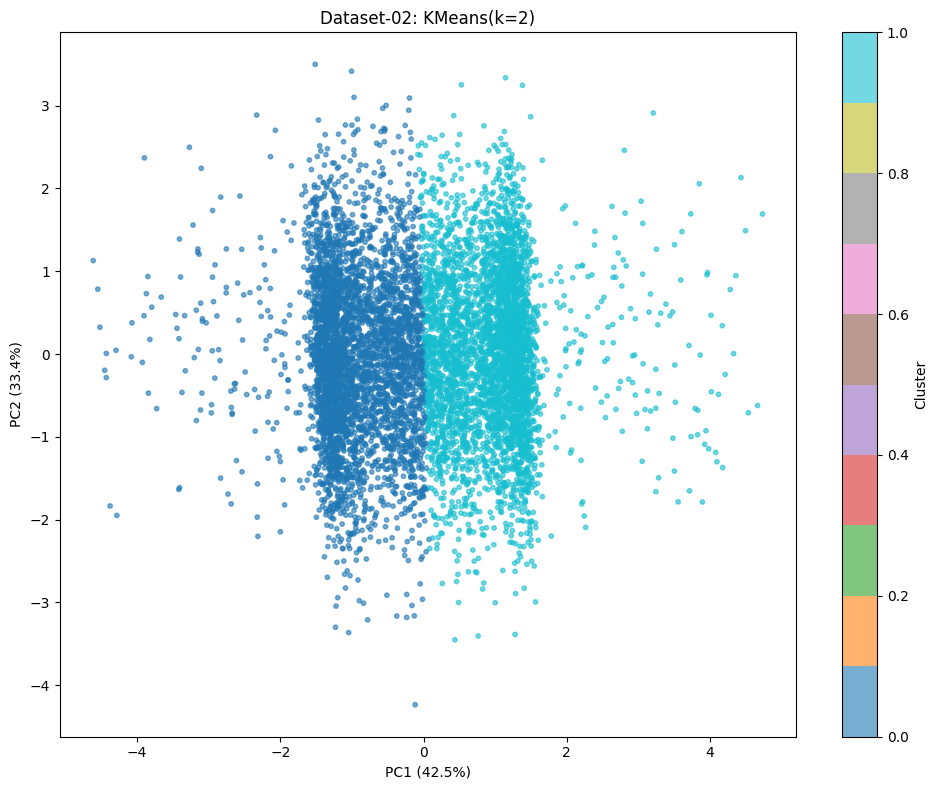

In [14]:
# DBSCAN для Dataset-02
dbscan_results_2 = []
for eps in [0.3, 0.5, 0.7, 1.0]:
    for min_s in [5, 10]:
        db = DBSCAN(eps=eps, min_samples=min_s)
        labels = db.fit_predict(X2)
        m = compute_metrics(X2, labels)
        m['eps'], m['min_samples'] = eps, min_s
        dbscan_results_2.append(m)

dbscan_df_2 = pd.DataFrame(dbscan_results_2)
dbscan_df_2 = dbscan_df_2[(dbscan_df_2['n_clusters'] >= 2) & (dbscan_df_2['noise_ratio'] < 0.5)]
dbscan_df_2 = dbscan_df_2.sort_values('silhouette', ascending=False)

if len(dbscan_df_2) > 0:
    best_db2 = dbscan_df_2.iloc[0]
    db2 = DBSCAN(eps=best_db2['eps'], min_samples=int(best_db2['min_samples']))
    labels_dbscan2 = db2.fit_predict(X2)
    metrics_dbscan2 = compute_metrics(X2, labels_dbscan2)
    print(f"DBSCAN: sil={metrics_dbscan2['silhouette']:.4f}, шум={metrics_dbscan2['noise_ratio']:.1%}")
else:
    metrics_dbscan2 = {'silhouette': -1}
    labels_dbscan2 = labels_kmeans2

# Лучший метод
if metrics_dbscan2['silhouette'] > metrics_kmeans2['silhouette']:
    best_labels_2, best_method_2, best_metrics_2 = labels_dbscan2, f"DBSCAN(eps={best_db2['eps']})", metrics_dbscan2
else:
    best_labels_2, best_method_2, best_metrics_2 = labels_kmeans2, f'KMeans(k={best_k_2})', metrics_kmeans2

print(f'\n✅ Лучший: {best_method_2}')
plot_pca_clusters(X2, best_labels_2, f'Dataset-02: {best_method_2}', 'artifacts/figures/pca_dataset02.png')


DATASET 03: Кластеры разной плотности + шум
Размер: (15000, 5)
Пропуски: 0


,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


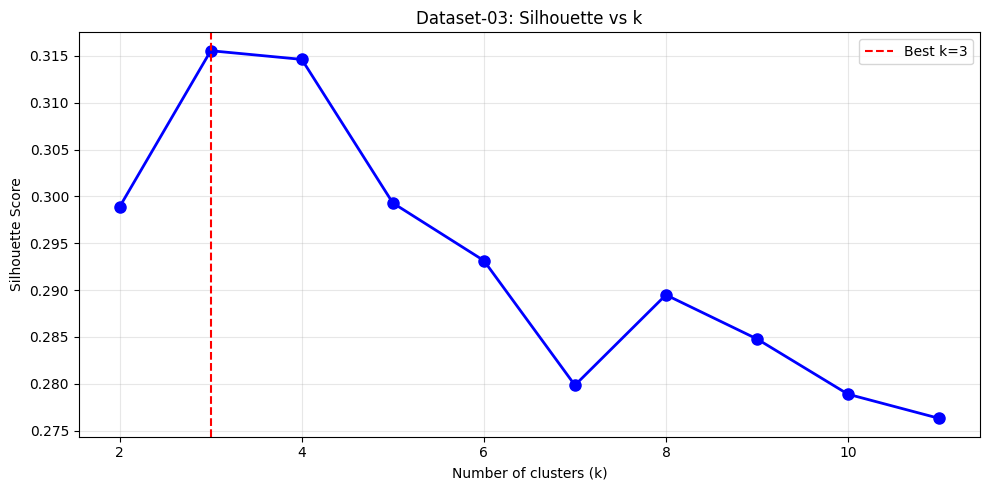

KMeans (k=3): sil=0.3155


In [15]:
# ========================================
# Dataset 03: Кластеры разной плотности
# ========================================
print("\n" + "="*60)
print("DATASET 03: Кластеры разной плотности + шум")
print("="*60)

df3 = pd.read_csv('data/S07-hw-dataset-03.csv')
print(f'Размер: {df3.shape}')
print(f'Пропуски: {df3.isnull().sum().sum()}')
display(df3.describe())

# Препроцессинг
sample_id_3 = df3['sample_id'].values
X3_raw = df3.drop(columns=['sample_id']).values
scaler3 = StandardScaler()
X3 = scaler3.fit_transform(X3_raw)

# KMeans
k_range_3 = range(2, 12)
best_k_3, best_sil_3 = plot_silhouette_vs_k(X3, k_range_3, 
    'Dataset-03: Silhouette vs k', 'artifacts/figures/silhouette_k_dataset03.png')

kmeans3 = KMeans(n_clusters=best_k_3, random_state=RANDOM_STATE, n_init=10)
labels_kmeans3 = kmeans3.fit_predict(X3)
metrics_kmeans3 = compute_metrics(X3, labels_kmeans3)
print(f'KMeans (k={best_k_3}): sil={metrics_kmeans3["silhouette"]:.4f}')

DBSCAN: sil=0.1437, шум=4.0%

✅ Лучший: KMeans(k=3)


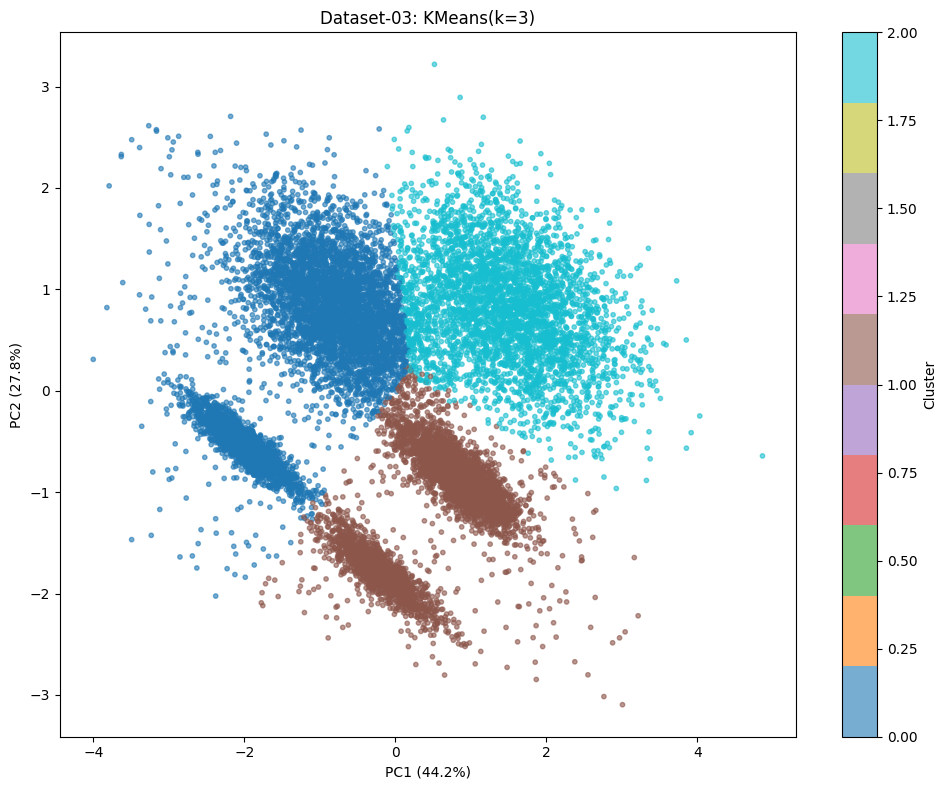

In [16]:
# DBSCAN для Dataset-03
dbscan_results_3 = []
for eps in [0.5, 0.7, 1.0, 1.5]:
    for min_s in [5, 10, 15]:
        db = DBSCAN(eps=eps, min_samples=min_s)
        labels = db.fit_predict(X3)
        m = compute_metrics(X3, labels)
        m['eps'], m['min_samples'] = eps, min_s
        dbscan_results_3.append(m)

dbscan_df_3 = pd.DataFrame(dbscan_results_3)
dbscan_df_3 = dbscan_df_3[(dbscan_df_3['n_clusters'] >= 2) & (dbscan_df_3['noise_ratio'] < 0.5)]
dbscan_df_3 = dbscan_df_3.sort_values('silhouette', ascending=False)

if len(dbscan_df_3) > 0:
    best_db3 = dbscan_df_3.iloc[0]
    db3 = DBSCAN(eps=best_db3['eps'], min_samples=int(best_db3['min_samples']))
    labels_dbscan3 = db3.fit_predict(X3)
    metrics_dbscan3 = compute_metrics(X3, labels_dbscan3)
    print(f"DBSCAN: sil={metrics_dbscan3['silhouette']:.4f}, шум={metrics_dbscan3['noise_ratio']:.1%}")
else:
    metrics_dbscan3 = {'silhouette': -1}
    labels_dbscan3 = labels_kmeans3

# Лучший метод
if metrics_dbscan3['silhouette'] > metrics_kmeans3['silhouette']:
    best_labels_3, best_method_3, best_metrics_3 = labels_dbscan3, f"DBSCAN(eps={best_db3['eps']})", metrics_dbscan3
else:
    best_labels_3, best_method_3, best_metrics_3 = labels_kmeans3, f'KMeans(k={best_k_3})', metrics_kmeans3

print(f'\n✅ Лучший: {best_method_3}')
plot_pca_clusters(X3, best_labels_3, f'Dataset-03: {best_method_3}', 'artifacts/figures/pca_dataset03.png')

## Проверка устойчивости (Dataset-01)

Проверяем устойчивость KMeans через ARI между запусками с разными random_state.

In [17]:
# Проверка устойчивости KMeans на Dataset-01
print("="*60)
print("ПРОВЕРКА УСТОЙЧИВОСТИ (Dataset-01, KMeans)")
print("="*60)

seeds = [0, 42, 123, 456, 789]
all_labels = []

for seed in seeds:
    km = KMeans(n_clusters=best_k_1, random_state=seed, n_init=10)
    labels = km.fit_predict(X1)
    all_labels.append(labels)

# ARI между всеми парами
ari_scores = []
for i in range(len(seeds)):
    for j in range(i+1, len(seeds)):
        ari = adjusted_rand_score(all_labels[i], all_labels[j])
        ari_scores.append(ari)
        print(f'ARI(seed={seeds[i]} vs seed={seeds[j]}): {ari:.4f}')

print(f'\n📊 Среднее ARI: {np.mean(ari_scores):.4f}')
print(f'📊 Std ARI: {np.std(ari_scores):.4f}')

if np.mean(ari_scores) > 0.9:
    print('\n✅ Результаты УСТОЙЧИВЫ (ARI > 0.9)')
else:
    print('\n⚠️ Результаты НЕУСТОЙЧИВЫ (ARI < 0.9)')

ПРОВЕРКА УСТОЙЧИВОСТИ (Dataset-01, KMeans)
ARI(seed=0 vs seed=42): 1.0000
ARI(seed=0 vs seed=123): 1.0000
ARI(seed=0 vs seed=456): 1.0000
ARI(seed=0 vs seed=789): 1.0000
ARI(seed=42 vs seed=123): 1.0000
ARI(seed=42 vs seed=456): 1.0000
ARI(seed=42 vs seed=789): 1.0000
ARI(seed=123 vs seed=456): 1.0000
ARI(seed=123 vs seed=789): 1.0000
ARI(seed=456 vs seed=789): 1.0000

📊 Среднее ARI: 1.0000
📊 Std ARI: 0.0000

✅ Результаты УСТОЙЧИВЫ (ARI > 0.9)


## Сохранение артефактов

In [18]:
# Сводка метрик
metrics_summary = {
    'dataset01': {
        'KMeans': {**metrics_kmeans1, 'k': best_k_1},
        'DBSCAN': metrics_dbscan1 if 'metrics_dbscan1' in dir() and metrics_dbscan1['silhouette'] != -1 else 'no valid clusters',
        'best_method': best_method_1
    },
    'dataset02': {
        'KMeans': {**metrics_kmeans2, 'k': best_k_2},
        'DBSCAN': metrics_dbscan2 if metrics_dbscan2['silhouette'] != -1 else 'no valid clusters',
        'best_method': best_method_2
    },
    'dataset03': {
        'KMeans': {**metrics_kmeans3, 'k': best_k_3},
        'DBSCAN': metrics_dbscan3 if metrics_dbscan3['silhouette'] != -1 else 'no valid clusters',
        'best_method': best_method_3
    }
}

with open('artifacts/metrics_summary.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2, default=str)
print('✅ Сохранено: artifacts/metrics_summary.json')

# Лучшие конфигурации
best_configs = {
    'dataset01': {'method': best_method_1, 'silhouette': best_metrics_1['silhouette'], 'criterion': 'max silhouette'},
    'dataset02': {'method': best_method_2, 'silhouette': best_metrics_2['silhouette'], 'criterion': 'max silhouette'},
    'dataset03': {'method': best_method_3, 'silhouette': best_metrics_3['silhouette'], 'criterion': 'max silhouette'}
}

with open('artifacts/best_configs.json', 'w') as f:
    json.dump(best_configs, f, indent=2)
print('✅ Сохранено: artifacts/best_configs.json')

# Сохранение labels
pd.DataFrame({'sample_id': sample_id_1, 'cluster_label': best_labels_1}).to_csv(
    'artifacts/labels/labels_dataset01.csv', index=False)
pd.DataFrame({'sample_id': sample_id_2, 'cluster_label': best_labels_2}).to_csv(
    'artifacts/labels/labels_dataset02.csv', index=False)
pd.DataFrame({'sample_id': sample_id_3, 'cluster_label': best_labels_3}).to_csv(
    'artifacts/labels/labels_dataset03.csv', index=False)
print('✅ Сохранены labels в artifacts/labels/')

✅ Сохранено: artifacts/metrics_summary.json
✅ Сохранено: artifacts/best_configs.json
✅ Сохранены labels в artifacts/labels/


## Итоговые выводы

### Сравнение алгоритмов

| Датасет | Особенности | KMeans | DBSCAN |
|---------|-------------|--------|--------|
| DS-01 | Разные шкалы признаков | Хорошо после scaling | Требует подбора eps |
| DS-02 | Шумовой признак | Чувствителен к шуму | Выделяет плотные области |
| DS-03 | Разная плотность кластеров | Устойчив | Проблемы с единым eps |

### Ключевые выводы

1. **Масштабирование критично** — без StandardScaler признаки в разных шкалах искажают расстояния
2. **KMeans** хорош для "шарообразных" кластеров, но чувствителен к выбросам
3. **DBSCAN** умеет выделять шум, но требует тщательного подбора eps и min_samples
4. **Внутренние метрики** (silhouette, DB, CH) помогают сравнивать решения, но не гарантируют "правильность"
5. **Устойчивость** (ARI между запусками) важна для доверия результатам